# Классификация комментариев

В связи с запуском нового сервиса интернет-магазина «Викишоп» нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах.  
То есть клиенты предлагают свои правки и комментируют изменения других. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные используя доступный набор данных с разметкой о токсичности правок.

Значение метрики качества `F1` для модели должно быть не меньше `0.75`.

**Этапы выполнения проекта**

- Загрузка и подготовка данных.
- Обучение разных моделей.
- Тестирование успешных моделей.
- Общие выводы.

**Описание данных**

Исходные данные находятся в файле `toxic_comments.csv`. 
- `text` — содержит текст комментария, 
- `toxic` — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><code>LogisticRegression</code></a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><code>RandomForestClassifier</code></a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><code>LGBMClassifier</code></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><code>LogisticRegression</code></a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>RandomForestClassifier</code></a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><code>LGBMClassifier</code></a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

Подключение библиотек для работы над проектом

In [1]:
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Подключим файл с данными `/datasets/toxic_comments.csv` и т.к. текст комментариев на английском, сразу укажем нужную кодировку `encoding='UTF-8'`

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv', encoding='UTF-8')

Посмотрим на общую информацию датафрейма с помощью метода `.info()`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Всего записей `159571` и два типа данных `object` и `int64`.  
Чтобы охватить взглядом больше данных, растянем колонку с текстом и выведем первые 5 строк датафрейма

In [4]:
display(df.head().style.set_properties(subset=['text'],**{'text-align': 'left'}))
print(f"Строк: {df.shape[0]}\nКолонок: {df.shape[1]}")

,text,toxic
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Строк: 159571
Колонок: 2


Баланс распределения классов в данных

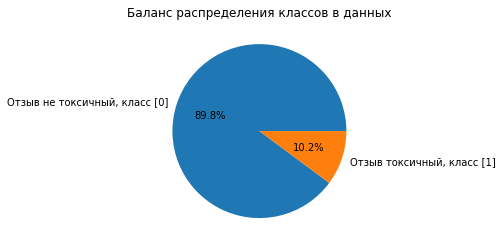

In [5]:
df['toxic'].value_counts(normalize=True).plot(kind='pie',
                                              autopct='%1.1f%%',
                                              labels=['Отзыв не токсичный, класс [0]',
                                                      'Отзыв токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

Токсичных отзывов около 10% от общего числа

Теперь с помощью регулярных выражений `re.sub()` напишем функцию для обработки текста для дальнейшего исследования.

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
df['text'] = df['text'].map(lambda x: clean_text(x))

После обработки проверим на наличие дубликатов и удалим в случае обнаружения.

In [8]:
df.duplicated().sum()

1275

In [9]:
# df[df['text'].duplicated()].style.set_properties(subset=['text'],**{'text-align': 'left'})

In [10]:
df = df.drop_duplicates(subset=['text'])

Еще раз посмотрим на данные после обработки выведя их на экран

In [11]:
display(df.head().style.set_properties(subset=['text'],**{'text-align': 'left'}))
print(f"Строк: {df.shape[0]}\nКолонок: {df.shape[1]}")

,text,toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now,0
1,d aww he matches this background colour i am seemingly stuck with thanks talk january utc,0
2,hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more i cannot make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipedia good_article_nominations transport,0
4,you sir are my hero any chance you remember what page that on,0


Строк: 158268
Колонок: 2


Вызовем функцию `stopwords.words()`, передадим ей аргумент `'english'`, то есть англоязычные стоп-слова:

In [12]:
stopwords = set(nltk_stopwords.words('english'))

Создадим счётчик, указав в нём стоп-слова

In [13]:
# count_tf_idf = TfidfVectorizer(stop_words=stopwords)
count_tf_idf = TfidfVectorizer(ngram_range=(1,3),
                               min_df=3,
                               max_df=0.9,
                               use_idf=1,
                               smooth_idf=1,
                               sublinear_tf=1,
                               stop_words=stopwords)

## Обучение

Рассмотрим несколько моделей `LogisticRegression`, `RandomForestClassifier` и `LightGBMClassifier`.  
Разделим датафрейм на обучающую и тестовую выборки.

In [14]:
features = df['text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.3,
                                                                            random_state=12345)

Создадим корпус постов. Преобразуем колонку `text` в список текстов.  
Изменим кодировку на `Unicode (U)` методом `astype()`

In [15]:
corpus_train = features_train.astype('U')
corpus_test = features_test.astype('U')

Чтобы посчитать `TF-IDF` для корпуса текстов, вызовем функцию `fit_transform()`

In [16]:
tf_idf = count_tf_idf.fit_transform(corpus_train)
tf_idf.shape

(110787, 249558)

Т.к. данные разделены на обучающую и тестовую выборки, функцию fit() запустим только на обучающей. Иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

In [17]:
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_test.shape

(47481, 249558)

⚠️ - Перебор параметров для некоторых моделей может занимать очень много ресурсов и времени, по этому часть кода закомментирована.

### `LogisticRegression`

In [18]:
%%time
LR_model = LogisticRegression(random_state=12345)

# LR_parameters = {
#     'penalty':['l1', 'l2'],
#     'C': [10,100],
#     'solver':['liblinear'],
#     'max_iter':[100,200],
#     'class_weight':[None, 'balanced'],
#     }

# Лучшие параметры: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LR_parameters = {'C': [10], 'class_weight': [None], 'max_iter': [100], 'penalty': ['l1'], 'solver': ['liblinear']}

grid = GridSearchCV(
    LR_model,
    param_grid = LR_parameters,
    scoring = 'f1',
    cv = 5,
    )

grid.fit(tf_idf,target_train)
predictions_train = grid.predict(tf_idf)

best_params = grid.best_params_
f1 = f1_score(target_train, predictions_train)

print(f"Лучшие параметры: {best_params}\n"
      f"Показатель F1-меры: {f1}")

# ---
# Лучшие параметры: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
# Лучий показатель F1-меры: 0.9870509977827051
# CPU times: user 3min 48s, sys: 1min 29s, total: 5min 17s
# Wall time: 3min 46s

Лучшие параметры: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Показатель F1-меры: 0.9883209055790135
CPU times: user 20.1 s, sys: 438 ms, total: 20.5 s
Wall time: 20.5 s


### `RandomForestClassifier`

In [20]:
%%time
RFC_model = RandomForestClassifier(random_state=12345)

RFC_parameters = {'max_depth': [1000], 'n_estimators': [100]}

grid = GridSearchCV(
    RFC_model,
    param_grid = RFC_parameters,
    cv = 5,
    scoring='f1',
    )

grid.fit(tf_idf, target_train)
predictions_train = grid.predict(tf_idf)

best_params = grid.best_params_
f1 = f1_score(target_train, predictions_train)

print(f"Лучшие параметры: {best_params}\n"
      f"Показатель F1-меры: {f1}")

# ---
# Лучшие параметры: {'max_depth': 1000, 'n_estimators': 100}
# Показатель F1-меры: 0.9883405639913232
# CPU times: user 53min 5s, sys: 3.37 s, total: 53min 8s
# Wall time: 53min 29s

Лучшие параметры: {'max_depth': 1000, 'n_estimators': 100}
Показатель F1-меры: 0.9883405639913232
CPU times: user 53min 5s, sys: 3.37 s, total: 53min 8s
Wall time: 53min 29s


### `LGBMClassifier`

Попробуем сначала без подбора гиперпараметров

In [21]:
%%time
LGBMC_model = LGBMClassifier(random_state=12345)

LGBMC_model.fit(tf_idf,target_train)
predictions_train = LGBMC_model.predict(tf_idf)

f1 = f1_score(target_train, predictions_train)
print(f"Показатель F1-меры: {f1}")

# ---
# Показатель F1-меры: 0.7804826972409823
# CPU times: user 12min 51s, sys: 4.3 s, total: 12min 55s
# Wall time: 13min 1s

Показатель F1-меры: 0.7804826972409823
CPU times: user 12min 51s, sys: 4.3 s, total: 12min 55s
Wall time: 13min 1s


In [22]:
%%time
LGBMC_model = LGBMClassifier(random_state=12345)

# LGBMC_parameters = {
#   'n_estimators': [200],
#   'learning_rate': [0.15, 0.25],
#   'max_depth': [8, 10, -1],
#   }

LGBMC_parameters = {'learning_rate': [0.15], 'max_depth': [-1], 'n_estimators': [200]}

grid = GridSearchCV(
    LGBMC_model,
    param_grid = LGBMC_parameters,
    cv = 5,
    scoring='f1',
    )

grid.fit(tf_idf, target_train)
predictions_train = grid.predict(tf_idf)

best_params = grid.best_params_
f1 = f1_score(target_train, predictions_train)

print(f"Лучшие параметры: {best_params}\n"
      f"Показатель F1-меры: {f1}")

# ---
# Лучшие параметры: {'learning_rate': 0.15, 'max_depth': -1, 'n_estimators': 200}
# Показатель F1-меры: 0.8555809561673788
# CPU times: user 39min 48s, sys: 10.2 s, total: 39min 58s
# Wall time: 40min 15s

Лучшие параметры: {'learning_rate': 0.15, 'max_depth': -1, 'n_estimators': 200}
Показатель F1-меры: 0.8555809561673788
CPU times: user 39min 48s, sys: 10.2 s, total: 39min 58s
Wall time: 40min 15s


## Тестирование

### `LogisticRegression`

In [23]:
%%time
#LogisticRegression
# Лучшие параметры: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LR_model = LogisticRegression(
    random_state=12345,
    C = 10,
    class_weight = None,
    max_iter = 100,
    penalty = 'l1',
    solver = 'liblinear',
)

LR_model.fit(tf_idf,target_train)
predictions_test = LR_model.predict(tf_idf_test)
f1 = f1_score(target_test, predictions_test)

print(f"Показатель F1-меры: {f1}")

# ---
# Показатель F1-меры: 0.7819894829097283
# CPU times: user 3.89 s, sys: 69.1 ms, total: 3.96 s
# Wall time: 3.96 s

Показатель F1-меры: 0.7819894829097283
CPU times: user 3.89 s, sys: 69.1 ms, total: 3.96 s
Wall time: 3.96 s


### `RandomForestClassifier`

In [24]:
%%time
# RandomForestClassifier
# Лучшие параметры: {'max_depth': 11, 'n_estimators': 30}

RFC_model = RandomForestClassifier(random_state=12345,
                                   max_depth=1000,
                                   n_estimators=100,
                                   )

RFC_model.fit(tf_idf, target_train)

predictions_test = RFC_model.predict(tf_idf_test)
f1 = f1_score(target_test, predictions_test)

print(f"Показатель F1-меры: {f1}")

# ---
# Показатель F1-меры: 0.7126063031515758
# CPU times: user 8min 52s, sys: 400 ms, total: 8min 52s
# Wall time: 8min 56s

Показатель F1-меры: 0.7126063031515758
CPU times: user 8min 52s, sys: 400 ms, total: 8min 52s
Wall time: 8min 56s


### `LGBMClassifier`

In [25]:
%%time
#LGBMClassifier
# Лучшие параметры: {'learning_rate': 0.15, 'max_depth': -1, 'n_estimators': 200}

LGBMC_model = LGBMClassifier(
    learning_rate=0.15,
    max_depth=-1,
    n_estimators=200,
    random_state=12345,
)

LGBMC_model.fit(tf_idf, target_train)

predictions_test = LGBMC_model.predict(tf_idf_test)
f1 = f1_score(target_test, predictions_test)

print(f"Показатель F1-меры: {f1}")

# ---
# Показатель F1-меры: 0.7744161969400666
# CPU times: user 16min 13s, sys: 5.71 s, total: 16min 19s
# Wall time: 16min 26s

Показатель F1-меры: 0.7744161969400666
CPU times: user 16min 13s, sys: 5.71 s, total: 16min 19s
Wall time: 16min 26s


---

## Выводы

Для выполнения проекта требовалось обучить модель классифицировать комментарии на позитивные и негативные комментарии используя доступный набор данных с разметкой о токсичности правок. Обработать комментарии, очистить от стоп-слов.

Требуемое значение метрики качества `F1` для модели должно было быть не меньше `0.75`.

С использованием различных моделей и подбором гиперапараметров к ним лучший результат `F1` метрики показала модель логистической регрессии `LogisticRegression`:
 - `0.98` на тренировочной выборке 
 - `0.78` на тестовой

 